# Includes

In [3]:
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

import os
import re
from datetime import datetime, timedelta
import numpy as np
from math import ceil, floor

In [4]:
import seaborn as sns
import umap
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression

# Load data

In [5]:
root_path = ""
data_dir = os.path.join(root_path, "unpacked")

data_files = os.listdir(data_dir)  # target files
data_files = [x for x in data_files if x != 'readme.txt']  # remove readme


def file_to_df(file):
    """Open file and create pandas data frame"""
    full_path = os.path.join(data_dir, file)
    return pd.read_csv(full_path, sep=';')

In [6]:
print(data_files)

['vehicle19_fuelLevel_public.csv', 'vehicle19_ingection_public.csv', 'vehicle19_refueling2_public.csv', 'vehicle19_speedAndHeight_public.csv', 'vehicle19_tachometer_public.csv', 'vehicle1_fuelLevel_public.csv', 'vehicle1_ingection_public.csv', 'vehicle1_refueling2_public.csv', 'vehicle1_speedAndHeight_public.csv', 'vehicle1_tachometer_public.csv', 'vehicle28_fuelLevel_public.csv', 'vehicle28_ingection_public.csv', 'vehicle28_refueling2_public.csv', 'vehicle28_speedAndHeight_public.csv', 'vehicle28_tachometer_public.csv', 'vehicle3_fuelLevel_public.csv', 'vehicle3_ingection_public.csv', 'vehicle3_refueling2_public.csv', 'vehicle3_speedAndHeight_public.csv', 'vehicle3_tachometer_public.csv', 'vehicle5_fuelLevel_public.csv', 'vehicle5_ingection_public.csv', 'vehicle5_refueling2_public.csv', 'vehicle5_speedAndHeight_public.csv', 'vehicle5_tachometer_public.csv']


## Get vehicle IDs

In [7]:
regex_pattern = r"vehicle(\d*)"  # ID is integer number comes right after vehicle word
compiled_pattern = re.compile(regex_pattern)
ids = compiled_pattern.findall(''.join(data_files))  # apply pattern to all file names
ids = set(ids)  # get a set of unique numbers
print(ids)

{'5', '19', '1', '28', '3'}


## Load info about a single vehicle

In [8]:
def open_file_id(v_id, key_lexem):
    """Key lexem determines file, for example, 'fuelLevel'"""
    regex_pattern = re.compile(f"(vehicle{v_id}_{key_lexem}" + r"_(\w|\d|_)*\.csv)")  # pattern to find appropriate name
    pattern_match = regex_pattern.search('|'.join(data_files))  # search on a whole file set
    needed_file = pattern_match.group(1)  # the file is found, now we can open it
    return file_to_df(needed_file)
    
possible_lexems = ['fuelLevel', 'ingection', 'refueling2', 'speedAndHeight', 'tachometer']

In [9]:
def load_all_files_id(v_id):
    """Generates a dictionary of all files describing a single vehicle"""
    return {lex: open_file_id(v_id, lex) for lex in possible_lexems}

# Task 3 - the mode of operation of equipment with the highest fuel consumption

In [10]:
  def plot_regplot(data, feature1, feature2, name):
    plt.figure(figsize=(10, 8))
    sns.regplot(x=feature1, y=feature2, data=data)
    plt.title(f'{feature1} and {feature2} relationship for {name} car')
    plt.grid()
    plt.show()

In [11]:
  def plot_scatterplot(data, feature1, name):
    plt.figure(figsize=(20, 8))
    sns.scatterplot(x=list(range(len(data[feature1].values))), y=data[feature1])
    plt.title(f'{feature1} for {name} car')
    plt.grid()
    plt.show()

In [12]:
raw_data_base = {v_id: load_all_files_id(v_id) for v_id in ids}  # load all data

Думаю, логично будет опираться на значение уровня топлива  в баке


In [13]:
dataset = {}
for i in ids:
    data = raw_data_base[i]['fuelLevel'].copy()
    data['fuel'] = data['BEVALUE'].apply(lambda x: float(re.sub(',','.',str(x))))
    data = data.drop(['BEVALUE'], axis=1)
    #data['ingection'] = raw_data_base[i]['ingection']['BEVALUE']
    
    data2 = raw_data_base[i]['ingection'].copy()
    data2['ingection'] = data2['BEVALUE']
    data2 = data2.drop(['BEVALUE'], axis=1)
    data2['speed'] = raw_data_base[i]['speedAndHeight']['SPEED']
    data2['tachometer'] = raw_data_base[i]['tachometer']['BEVALUE']
    
    
    data = pd.merge(data, data2, how='inner', on=['DTIME'])
    
    data['DTIME'] = pd.to_datetime(data['DTIME'])
    data['date'] = data['DTIME'].apply(lambda x: x.date())
    data['time'] = data['DTIME'].apply(lambda x: x.time())
    dataset[i] = data.copy()

Сразу исключим значения с выключенным зажиганием и когда двигатель заглушен.

In [14]:
for name in dataset:
    data = dataset[name]
    data = data[data['ingection'] == 1]
    data = data[data['tachometer'] > 0]
    dataset[name] = data

Давайте для всех транспортных стредств посмотрим как меняется уровень топлива в баке

In [15]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series.values[0]] # first value is same as series
    for n in range(1, len(series.values)):
        result.append(alpha * series.values[n] + (1 - alpha) * result[n-1])
    return result

Сделаем два набора данных. В одном будет лежать сырые данные, а в другом сглаженные.

In [16]:
smooth_dataset = {}
for name in dataset:
    smooth_dataset[name] = dataset[name].copy()
    smooth_dataset[name]['fuel'] = exponential_smoothing(dataset[name]['fuel'], 0.1)

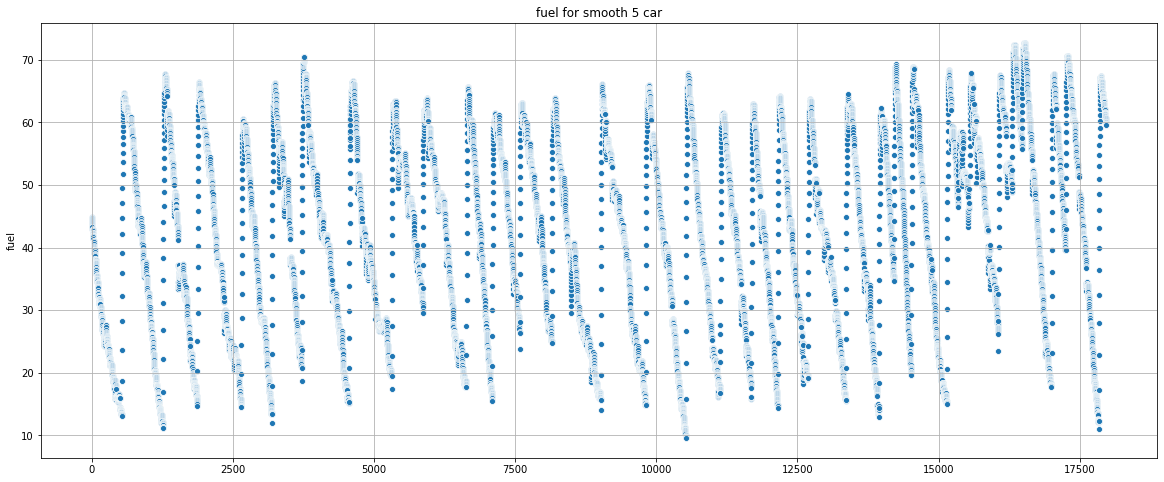

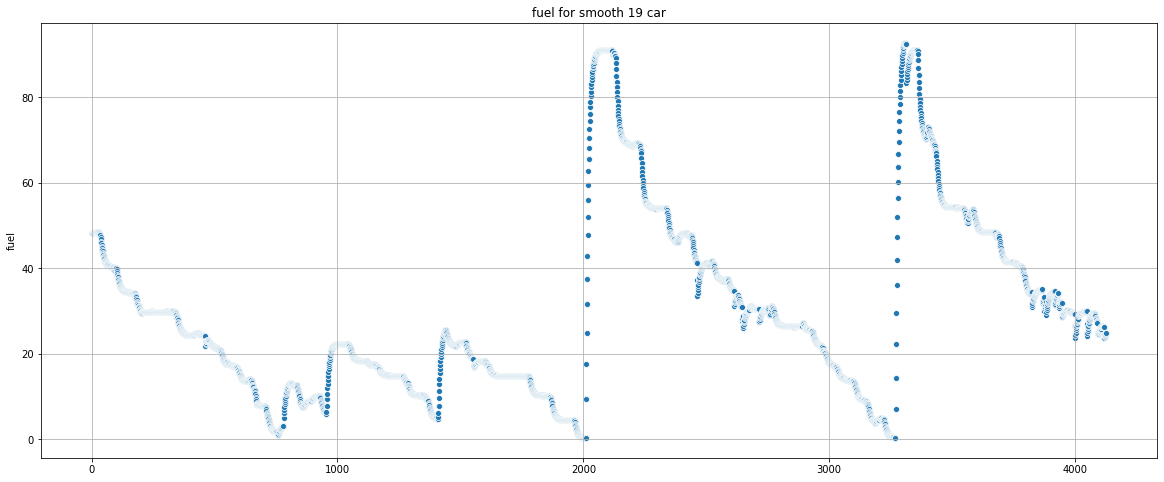

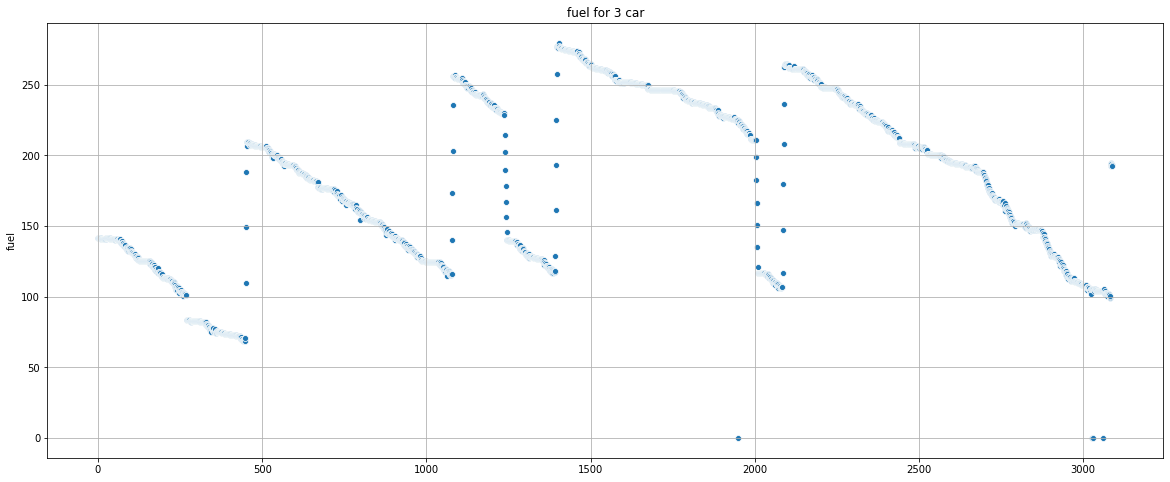

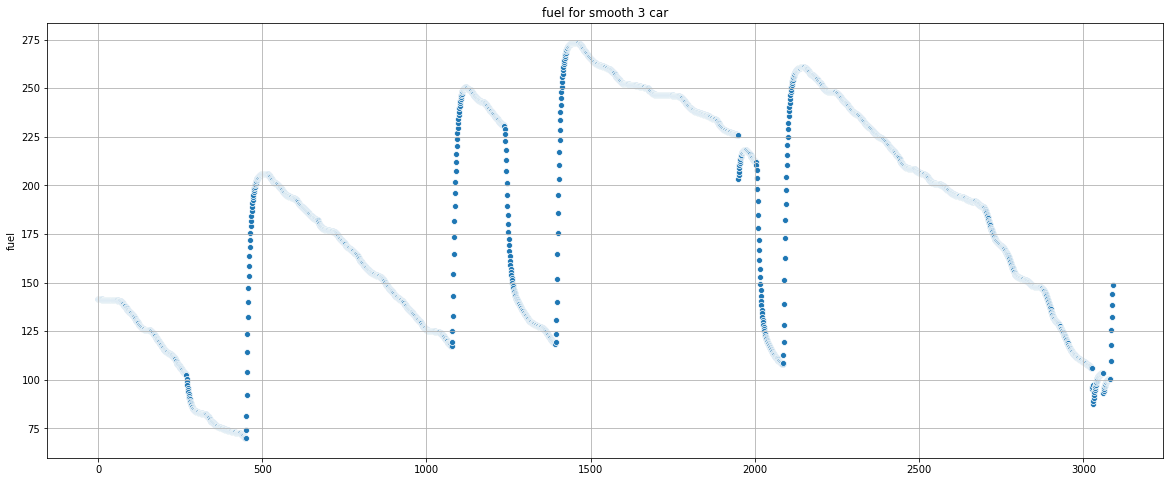

In [17]:
for name in dataset:
    plot_scatterplot(dataset[name], 'fuel', name)
    plot_scatterplot(smooth_dataset[name], 'fuel', 'smooth ' + name)

В целом, внешний вид результатов ожидаемый.

Давайте найдем разность топлива на соседних отметках и разделим на продолжитедьность этого этапа.

In [18]:
def get_delta(data, feature):
    fuel = data[feature].values[0]
    time = data['DTIME'].values[0]
    result = []
    for f, t in zip(data[feature], data['DTIME']):
        result.append((f-fuel) / ((t - time).total_seconds() + 1e-9))
        time = t
        fuel = f
    return result

In [19]:
for name in dataset:
    dataset[name]['df'] = get_delta(dataset[name], 'fuel')
    smooth_dataset[name]['df'] = get_delta(smooth_dataset[name], 'fuel')

И будем рассматривать только интервалы с расходом топлива

In [20]:
for name in dataset:
    dataset[name] = dataset[name][dataset[name]['df']< 0]
    smooth_dataset[name] = smooth_dataset[name][smooth_dataset[name]['df']< 0]

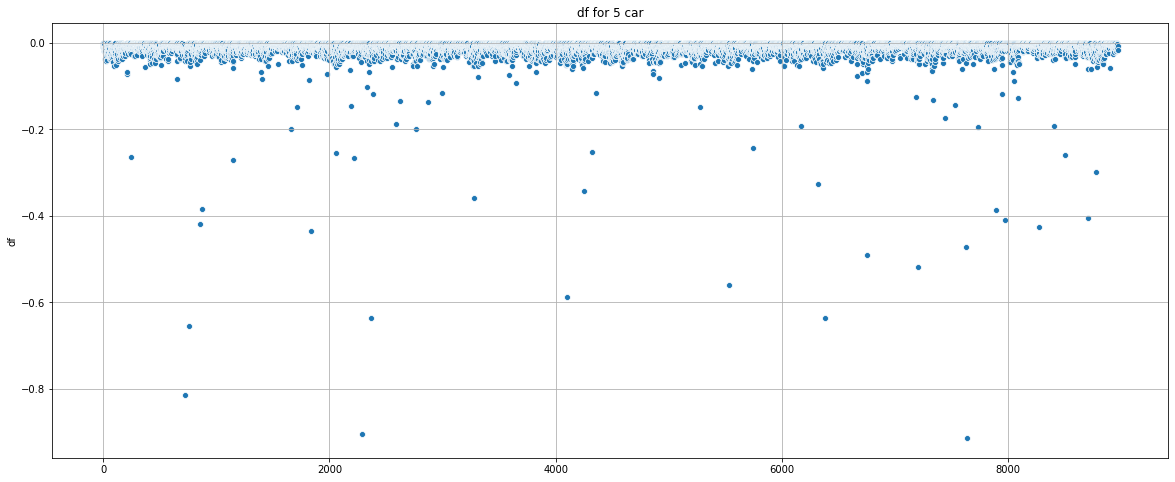

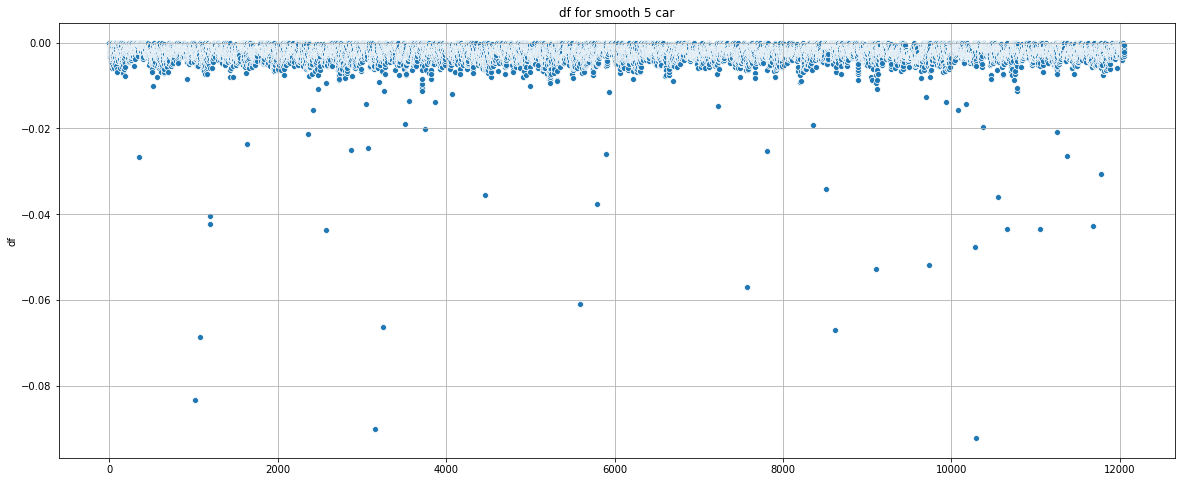

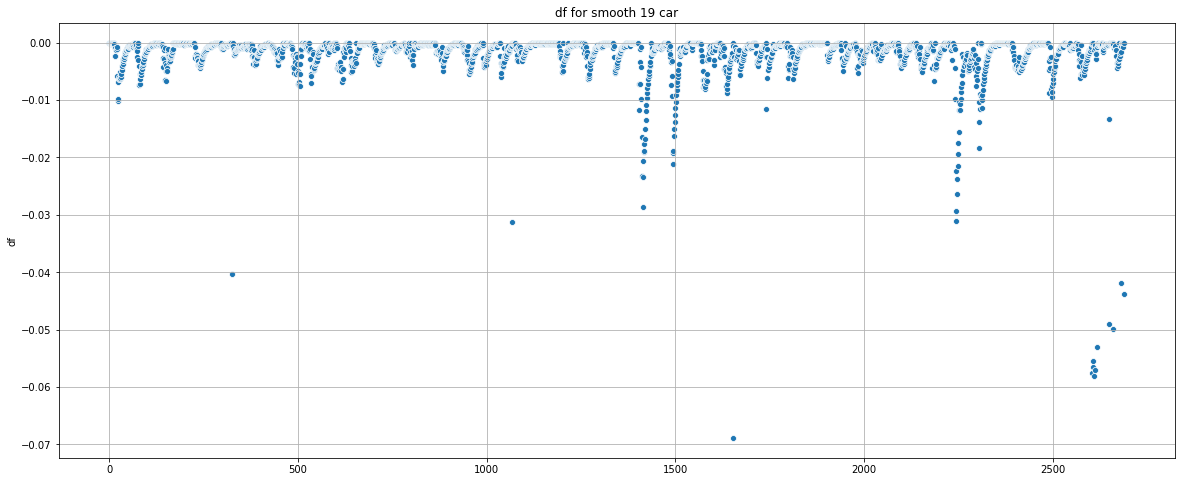

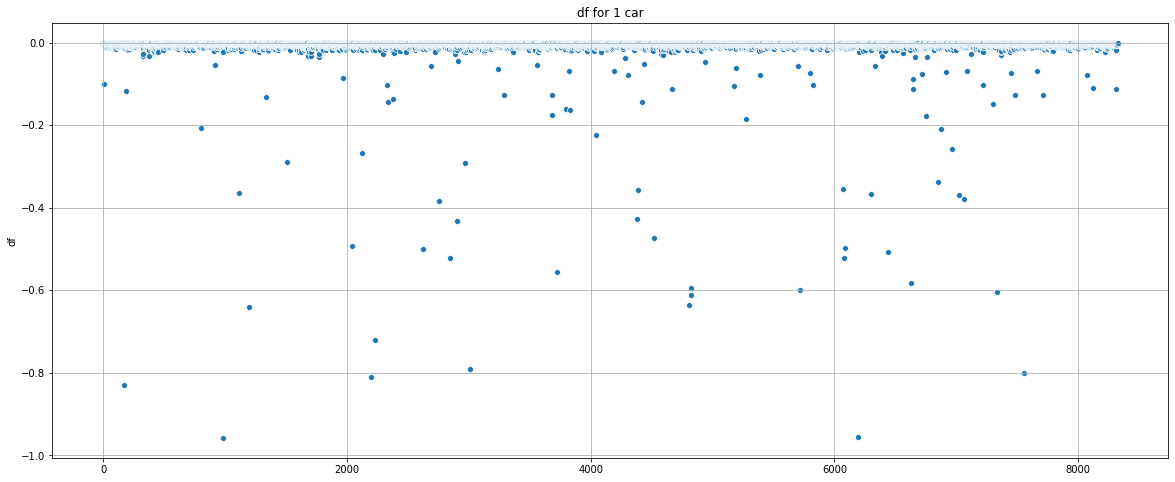

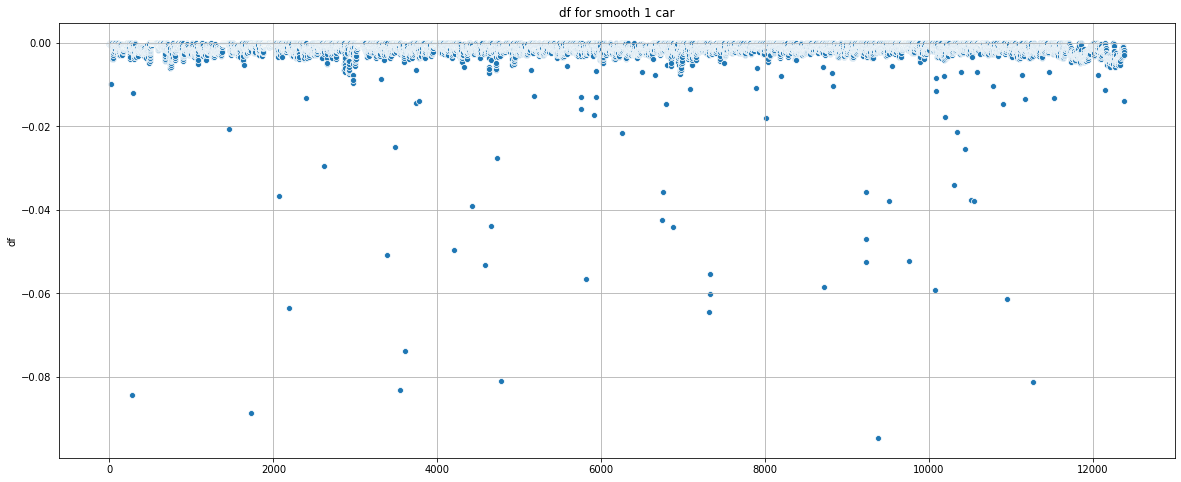

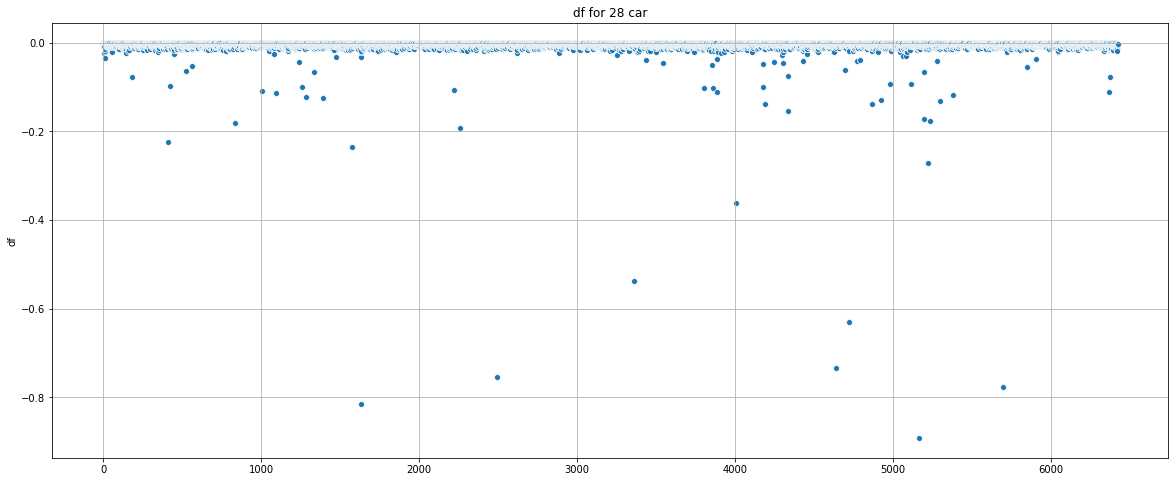

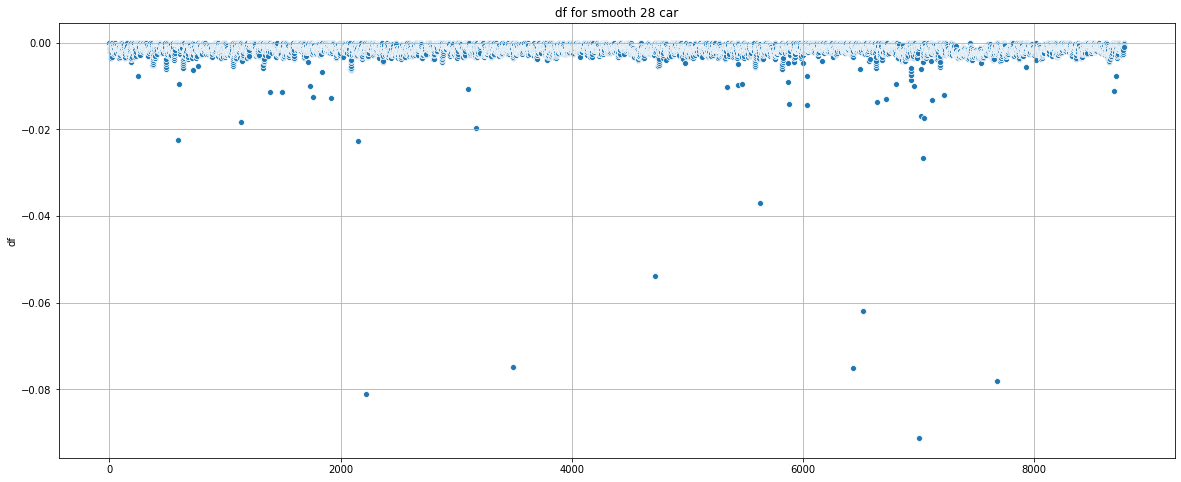

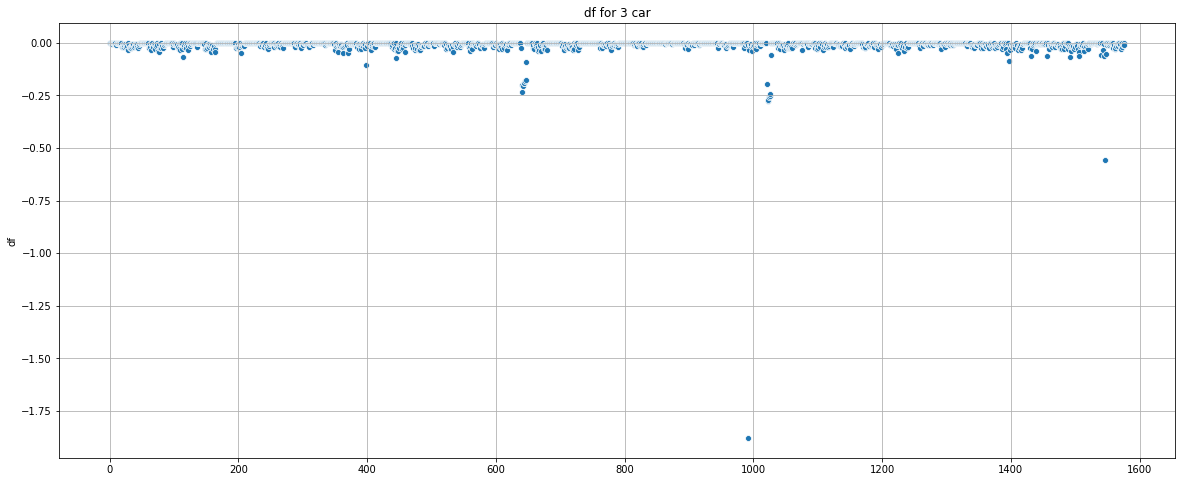

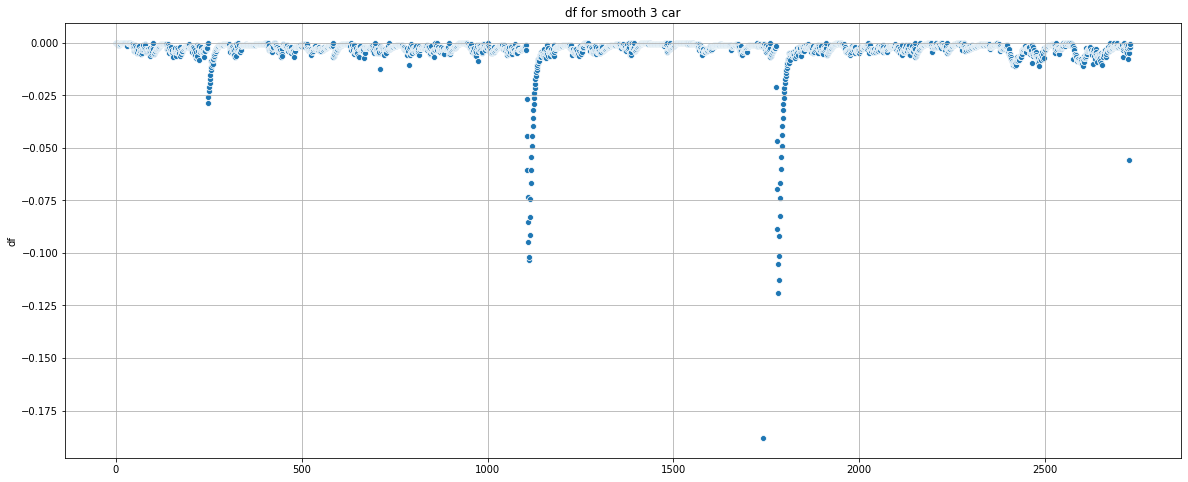

In [21]:
for name in dataset:
    plot_scatterplot(dataset[name], 'df', name)
    plot_scatterplot(smooth_dataset[name], 'df', 'smooth ' + name)

In [22]:
def boxplot(data):
    plt.figure(figsize=(10, 8))
    sns.boxplot(data)
    plt.title(f'boxplot of df')
    plt.grid()
    plt.show()

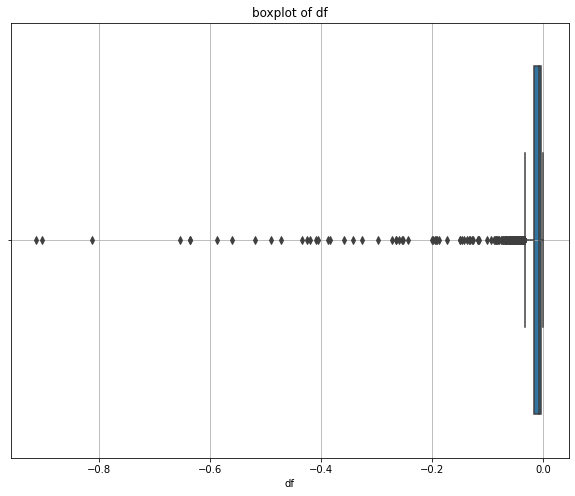

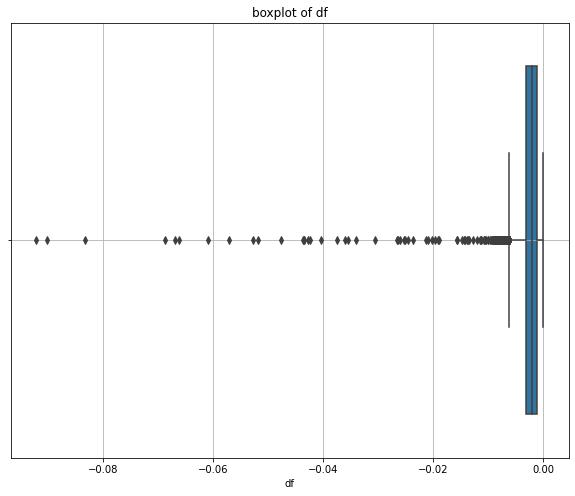

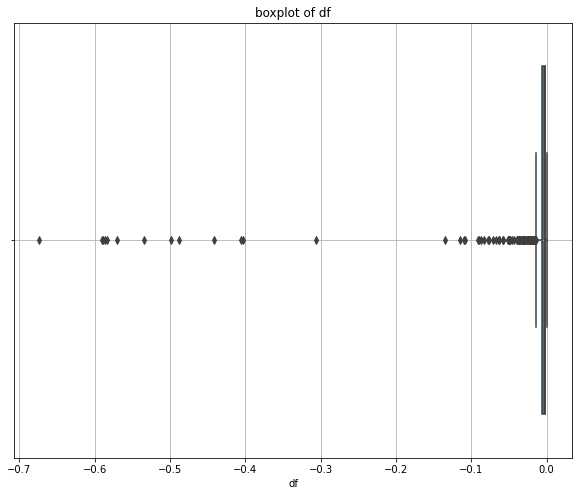

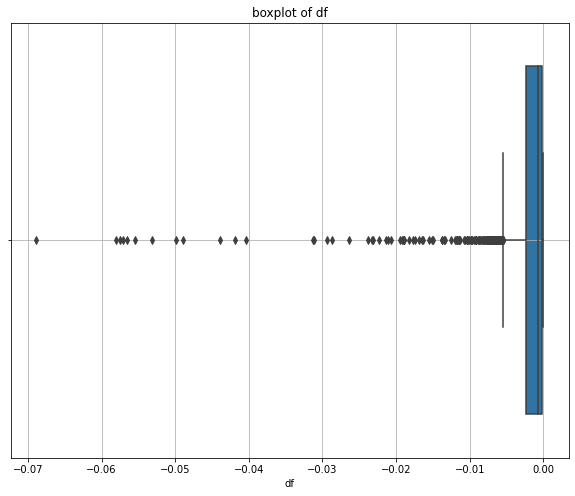

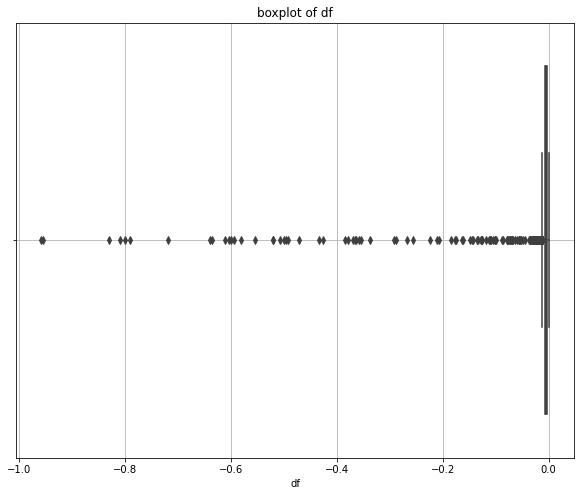

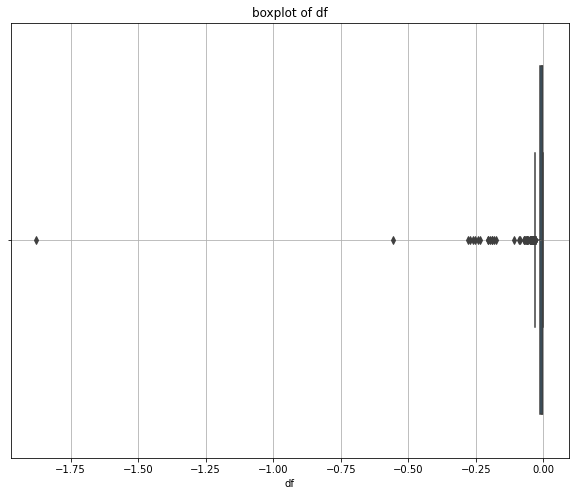

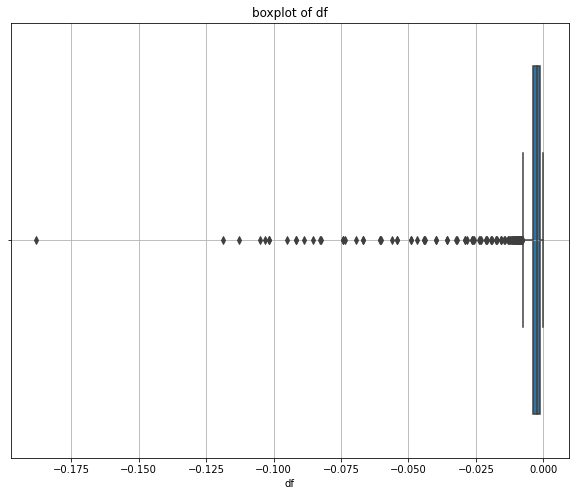

In [23]:
for name in dataset:
    boxplot(dataset[name]['df'])
    boxplot(smooth_dataset[name]['df'])

Видим, что все очень прижато к нулю.

Я думаю, установить границу для большого расхода топлива, это то, что по модулю попадает в 4 квартиль.

In [24]:
for name in dataset:
    q1 = float(dataset[name]['df'].quantile(0.25))
    q1s = float(smooth_dataset[name]['df'].quantile(0.25))
    
    dataset[name]['mode'] = ['greedy' if x < q1 else 'normal' for x in dataset[name]['df']]
    smooth_dataset[name]['mode'] = ['greedy' if x < q1 else 'normal' for x in smooth_dataset[name]['df']]

e:\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Получим индексы наших выскорасходных интервалов

In [25]:
index = {}
index_s = {}
for name in dataset:
    index[name] = dataset[name][dataset[name]['mode'] == 'greedy'].index
    index_s[name] = smooth_dataset[name][smooth_dataset[name]['mode'] == 'greedy'].index

И попробуем изобразить на изначальных данных

Так как мы сильно поиздевались над исходными данными, давайте их снова соберем

In [26]:
dataset = {}
for i in ids:
    data = raw_data_base[i]['fuelLevel'].copy()
    data['fuel'] = data['BEVALUE'].apply(lambda x: float(re.sub(',','.',str(x))))
    data = data.drop(['BEVALUE'], axis=1)
    
    data2 = raw_data_base[i]['ingection'].copy()
    data2['ingection'] = data2['BEVALUE']
    data2 = data2.drop(['BEVALUE'], axis=1)
    data2['speed'] = raw_data_base[i]['speedAndHeight']['SPEED']
    data2['tachometer'] = raw_data_base[i]['tachometer']['BEVALUE']
    
    
    data = pd.merge(data, data2, how='inner', on=['DTIME'])
    
    data['DTIME'] = pd.to_datetime(data['DTIME'])
    data['date'] = data['DTIME'].apply(lambda x: x.date())
    data['time'] = data['DTIME'].apply(lambda x: x.time())
    
    data['index'] = data.index
    
    data['mode'] = ['freedy' if x in index[i] else 'normal' for x in data['index']]
    data['mode_smooth'] = ['freedy' if x in index_s[i] else 'normal' for x in data['index']]
    
    dataset[i] = data.copy()

In [27]:
def plot_scatterplot2(data, hue, name):
    plt.figure(figsize=(20 ,8 ))
    
    sns.scatterplot('index', 'fuel', data=data, hue=hue)
    
    plt.title(f'the {hue} for {name} car')
    plt.grid()
    plt.show()

И посмотрим результаты на состоянии бака

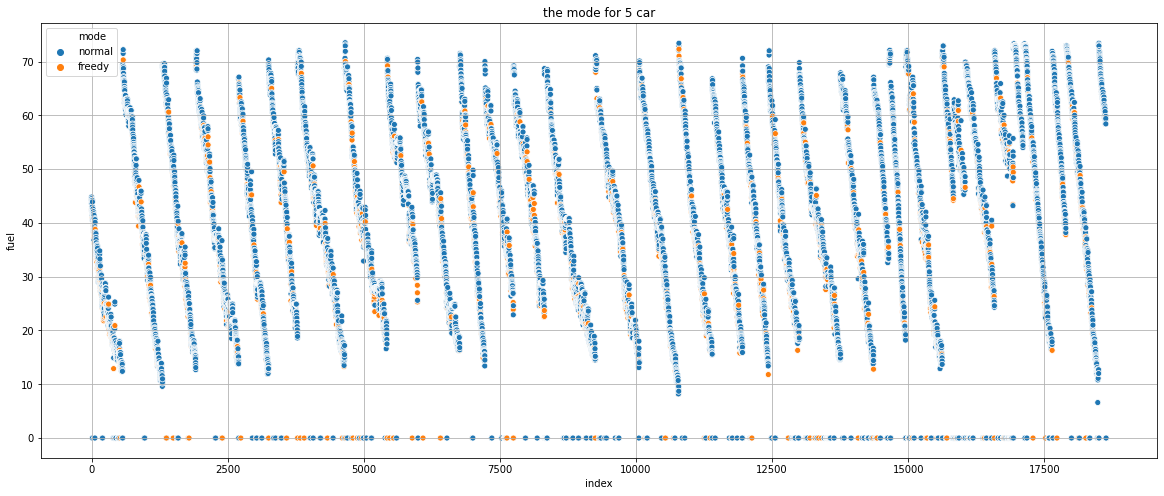

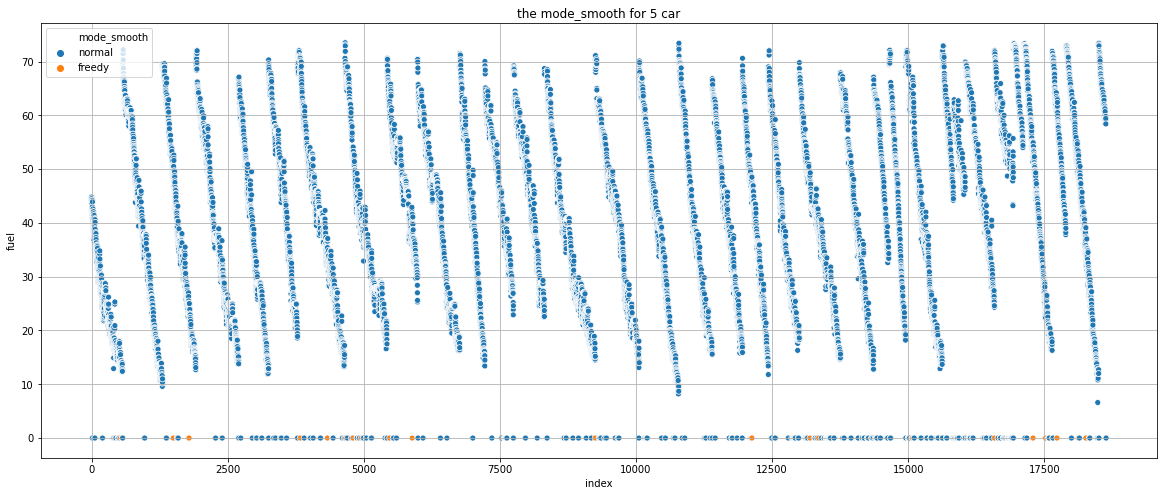

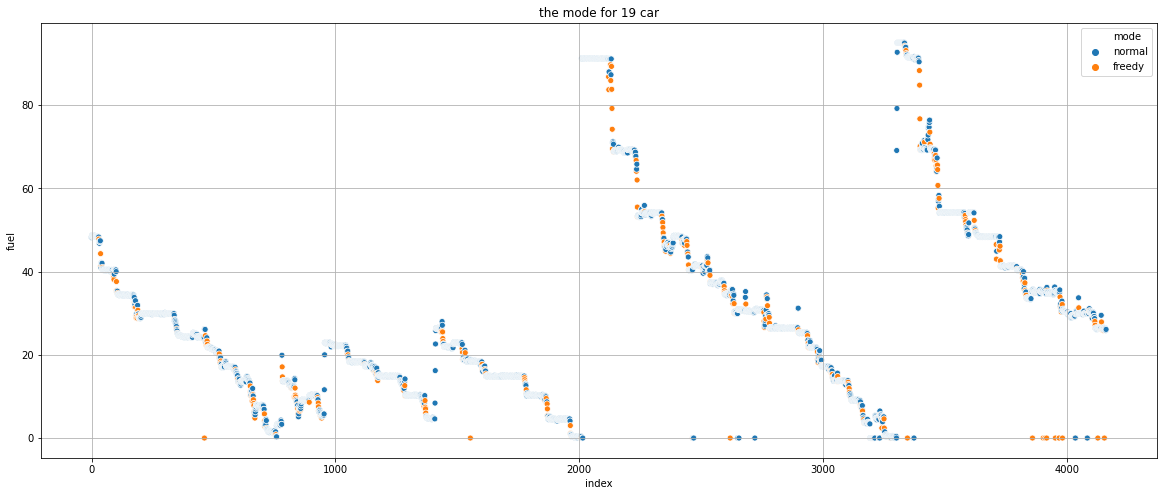

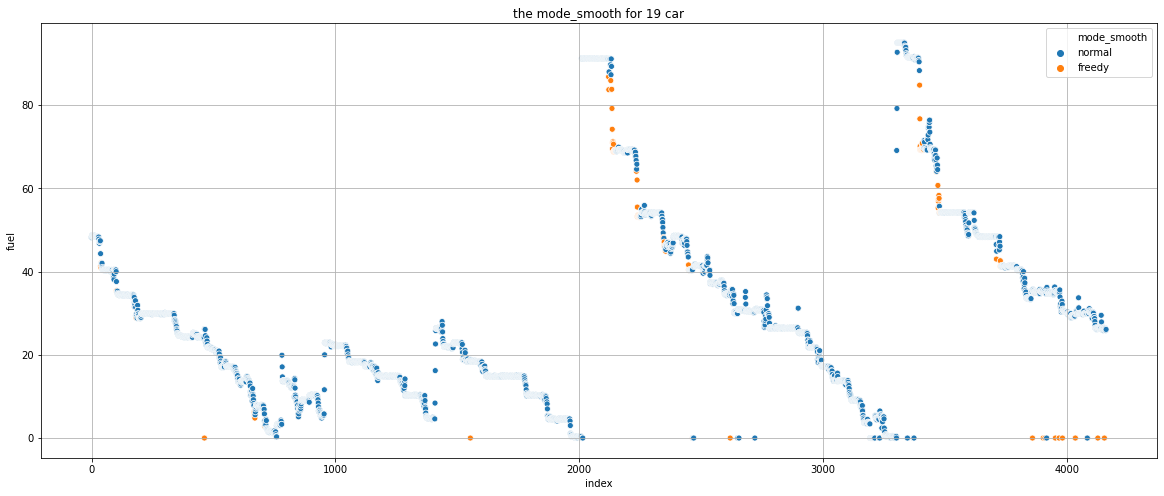

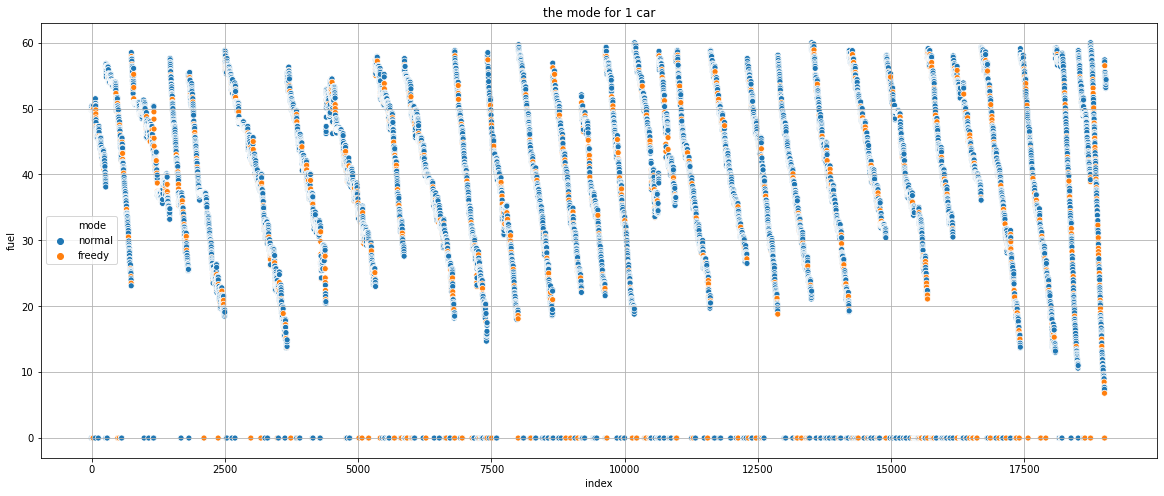

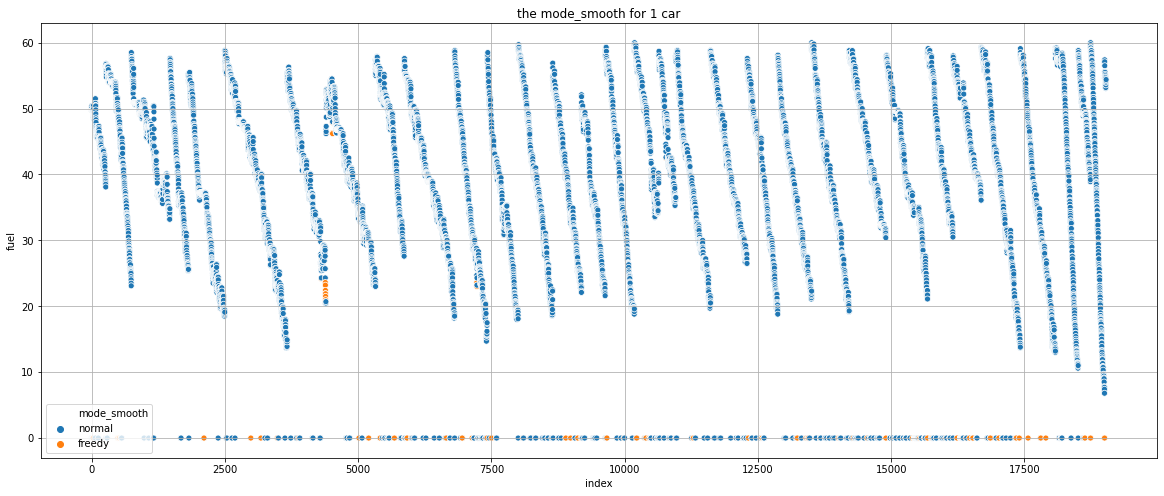

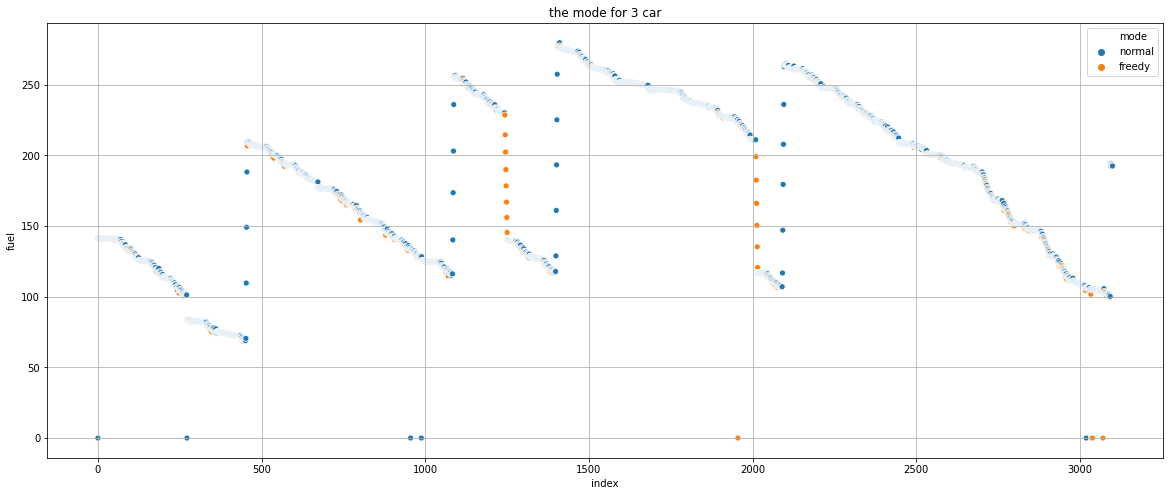

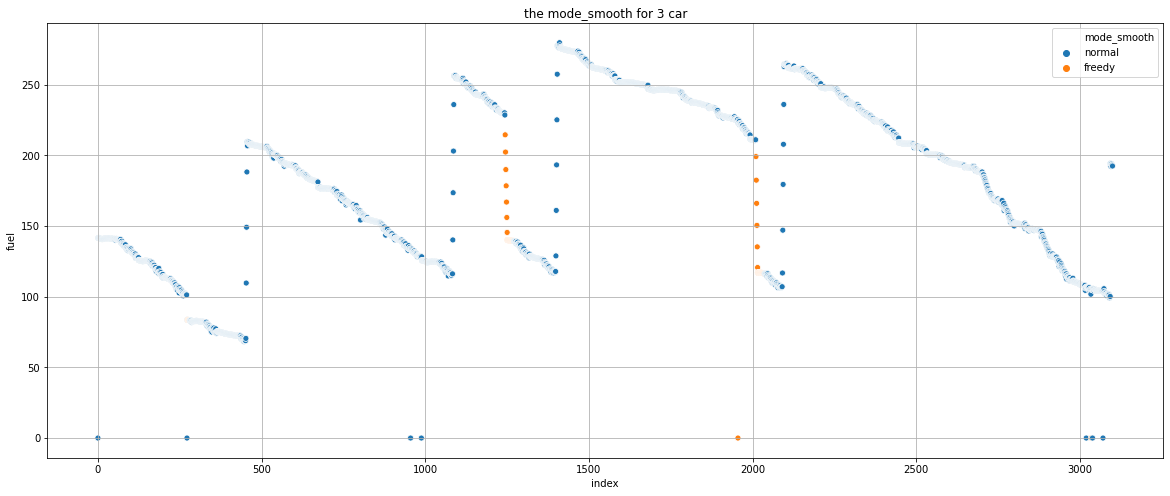

In [28]:
for name in dataset:
    plot_scatterplot2(dataset[name], 'mode', name)
    plot_scatterplot2(dataset[name], 'mode_smooth', name)

По графикам видно, что алгоритм находит самые сильные траты топлива достаточно точно. Можно регулировать границу принятия решения всего одним числом, это то, кокой квантиль мы берем.

Сглаженный алгоритм менее чувствителен, но его так же можно настраивать параметром сглаживания $alpha$. 